In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Air Quality Ho Chi Minh City.csv", parse_dates=['date'])

C:\Users\ACER\AppData\Local\Temp\ipykernel_19412\2853000406.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("Air Quality Ho Chi Minh City.csv", parse_dates=['date'])


 Breakpoints AQI (US EPA)

In [3]:
BREAKPOINTS = {
    "PM2.5": [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500),
    ],
    "O3": [  # 8h average, ppm
        (0.000, 0.054, 0, 50),
        (0.055, 0.070, 51, 100),
        (0.071, 0.085, 101, 150),
        (0.086, 0.105, 151, 200),
        (0.106, 0.200, 201, 300),
    ],
    "CO": [  # ppm (8h)
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400),
        (40.5, 50.4, 401, 500),
    ],
    "NO2": [  # ppb (1h)
        (0, 53, 0, 50),
        (54, 100, 51, 100),
        (101, 360, 101, 150),
        (361, 649, 151, 200),
        (650, 1249, 201, 300),
        (1250, 1649, 301, 400),
        (1650, 2049, 401, 500),
    ],
    "SO2": [  # ppb (1h)
        (0, 35, 0, 50),
        (36, 75, 51, 100),
        (76, 185, 101, 150),
        (186, 304, 151, 200),
        (305, 604, 201, 300),
        (605, 804, 301, 400),
        (805, 1004, 401, 500),
    ],
}

In [4]:
def calc_sub_index(c, breakpoints):
    """Nội suy tuyến tính để tính sub-index AQI"""
    for (Cl, Ch, Il, Ih) in breakpoints:
        if Cl <= c <= Ch:
            return (Ih - Il) / (Ch - Cl) * (c - Cl) + Il
    return np.nan

def add_aqi_columns(df):
    """
    Input: DataFrame gốc
    Output: Thêm 2 cột AQI và Dominant (dùng để phân tích, không train)
    """
    df = df.copy()
    # Đổi đơn vị nếu cần: O3 và CO thường ghi ở ppb → đổi sang ppm
    if df['O3'].max() > 1:
        df['O3'] = df['O3'] / 1000
    if df['CO'].max() > 50:
        df['CO'] = df['CO'] / 1000

    sub_indices = {}
    for pol in BREAKPOINTS.keys():
        sub_indices[pol] = df[pol].apply(lambda x: calc_sub_index(x, BREAKPOINTS[pol]))

    sub_df = pd.DataFrame(sub_indices)
    df['AQI'] = sub_df.max(axis=1)
    df['Dominant'] = sub_df.idxmax(axis=1)
    return df

In [5]:
# Tính AQI + Dominant
df = add_aqi_columns(df)

# Xem vài dòng kết quả
print(df[['date','PM2.5','O3','CO','NO2','SO2','AQI','Dominant']].head())

                 date      PM2.5        O3        CO         NO2         SO2  \
0 2021-02-23 21:00:00  15.604762  0.055431  1.330451  112.740762  393.000000   
1 2021-02-23 22:00:00  14.594118  0.058197  1.200604  112.366471  377.588235   
2 2021-02-23 23:00:00  13.436667  0.055029  1.177897  112.700433  372.476667   
3 2021-02-24 00:00:00  12.365000  0.054768  1.267476  112.480867  389.070000   
4 2021-02-24 01:00:00  11.636667  0.053786  1.322293  114.331500  393.000000   

          AQI Dominant  
0  230.137124      SO2  
1  225.034232      SO2  
2  223.341773      SO2  
3  228.835886      SO2  
4  230.137124      SO2  


C:\Users\ACER\AppData\Local\Temp\ipykernel_19412\252065822.py:26: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['Dominant'] = sub_df.idxmax(axis=1)


In [6]:
df_station = df[df["Station_No"] == 1].copy()

features = ["PM2.5","O3","CO","NO2","SO2","Temperature","Humidity"]
targets  = ["PM2.5","O3","CO","NO2","SO2"]

df_ml = df_station[features].dropna().reset_index(drop=True)

In [7]:
split = int(len(df_ml) * 0.8)
train_df = df_ml.iloc[:split]
test_df  = df_ml.iloc[split:]

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled  = scaler.transform(test_df)

train_scaled = pd.DataFrame(train_scaled, columns=features)
test_scaled  = pd.DataFrame(test_scaled, columns=features)

In [9]:
def create_sequences_multivariate(data, target_cols, window_size=48, horizon=1):
    X, y = [], []
    values = data.values
    target_idx = [data.columns.get_loc(c) for c in target_cols]
    
    for i in range(len(values) - window_size - horizon + 1):
        X.append(values[i:i+window_size, :])  # all features
        y.append(values[i+window_size+horizon-1, target_idx])  # targets: pollutants
    return np.array(X), np.array(y)

WINDOW_SIZE = 48
X_train, y_train = create_sequences_multivariate(train_scaled, targets, window_size=WINDOW_SIZE, horizon=1)
X_test, y_test   = create_sequences_multivariate(test_scaled, targets, window_size=WINDOW_SIZE, horizon=1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1696, 48, 7)
y_train shape: (1696, 5)
X_test shape: (388, 48, 7)
y_test shape: (388, 5)


In [34]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# GRU model
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(WINDOW_SIZE, len(features))),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(len(targets))   # multi-output: pollutants
])
model.compile(optimizer="adam", loss="mae")
model.summary()


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 48, 128)        │        52,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,101 (359.77 KB)

 Trainable params: 92,101 (359.77 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.1303 - val_loss: 0.1224 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0871 - val_loss: 0.1207 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0750 - val_loss: 0.1118 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0686 - val_loss: 0.0963 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0648 - val_loss: 0.0948 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0609 - val_loss: 0.0869 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0582 - val_loss: 0.0841 - learning_rate: 0.0010
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0546 - val_loss: 0.0725 - learning_rate: 0.0010
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0532 - val_loss: 0.0687 - learning_rate: 0.0010
Epoch 10/1

In [36]:
y_pred = model.predict(X_test)

# Inverse transform để quay về giá trị gốc
# Chú ý: cần ghép lại vào DataFrame để inverse đúng cột
df_tmp = np.zeros((len(y_pred), len(features)))
df_tmp[:, :len(targets)] = y_pred
inv_pred = scaler.inverse_transform(df_tmp)[:, :len(targets)]

pred_df = pd.DataFrame(inv_pred, columns=targets)

print(pred_df.head())

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
       PM2.5        O3        CO         NO2         SO2
0  11.331514  0.123488  0.906914  170.555663  199.443272
1  13.392411  0.111155  0.985170  167.797371  217.004061
2  14.042100  0.104288  0.972102  164.554474  211.082399
3  14.321684  0.080856  0.798944  121.954520  187.764110
4  14.759473  0.087560  0.749892  125.333194  172.429210


In [37]:
# y_pred sau khi inverse_transform thành dataframe
pred_df = pd.DataFrame(inv_pred, columns=["PM2.5","O3","CO","NO2","SO2"])

# Thêm AQI và Dominant từ pollutants dự báo
pred_df_aqi = add_aqi_columns(pred_df)

print(pred_df_aqi.head())


       PM2.5        O3        CO         NO2         SO2         AQI Dominant
0  11.331514  0.123488  0.906914  170.555663  199.443272  219.418081       O3
1  13.392411  0.111155  0.985170  167.797371  217.004061  206.429222       O3
2  14.042100  0.104288  0.972102  164.554474  211.082399  198.164952       O3
3  14.321684  0.080856  0.798944  121.954520  187.764110  151.732554      SO2
4  14.759473  0.087560  0.749892  125.333194  172.429210  155.024398       O3


In [38]:
# 1. AQI thật từ y_test
y_test_df = pd.DataFrame(scaler.inverse_transform(
    np.hstack([y_test, np.zeros((len(y_test), len(features)-len(targets)))]))[:, :len(targets)],
    columns=targets
)
true_aqi = add_aqi_columns(y_test_df)

# 2. AQI dự báo từ y_pred
y_pred_df = pd.DataFrame(inv_pred, columns=targets)
pred_aqi = add_aqi_columns(y_pred_df)

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(true_aqi["AQI"], pred_aqi["AQI"])
rmse = np.sqrt(mean_squared_error(true_aqi["AQI"], pred_aqi["AQI"]))

print("MAE AQI:", mae)
print("RMSE AQI:", rmse)

# Accuracy Dominant
acc_dom = (true_aqi["Dominant"] == pred_aqi["Dominant"]).mean()
print("Dominant pollutant accuracy:", acc_dom)

MAE AQI: 17.167882433537027
RMSE AQI: 23.119354738380636
Dominant pollutant accuracy: 0.8427835051546392


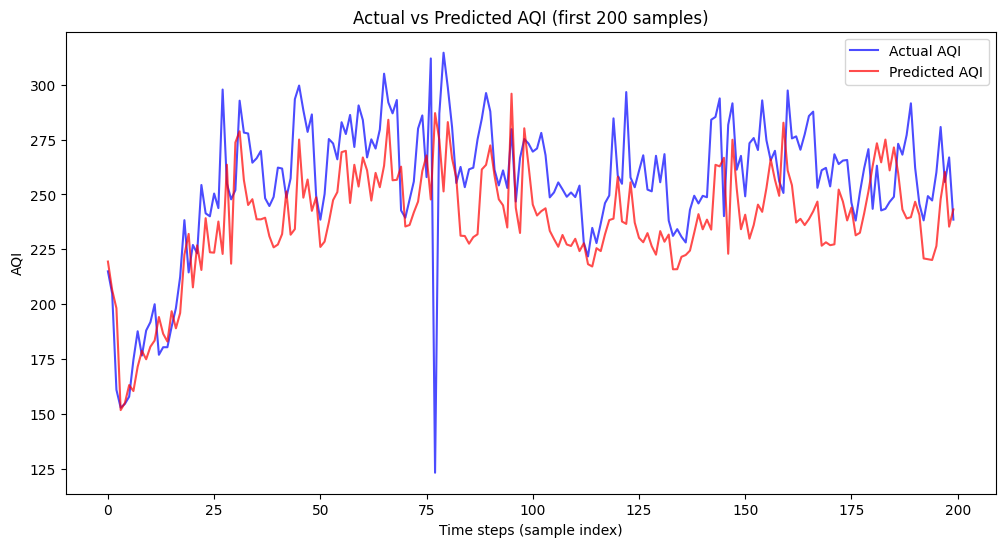

In [40]:
import matplotlib.pyplot as plt

# Vẽ AQI thật vs AQI dự báo
plt.figure(figsize=(12,6))
plt.plot(true_aqi["AQI"].values[:200], label="Actual AQI", color="blue", alpha=0.7) # type: ignore
plt.plot(pred_aqi["AQI"].values[:200], label="Predicted AQI", color="red", alpha=0.7) # type: ignore
plt.xlabel("Time steps (sample index)")
plt.ylabel("AQI")
plt.title("Actual vs Predicted AQI (first 200 samples)")
plt.legend()
plt.show()


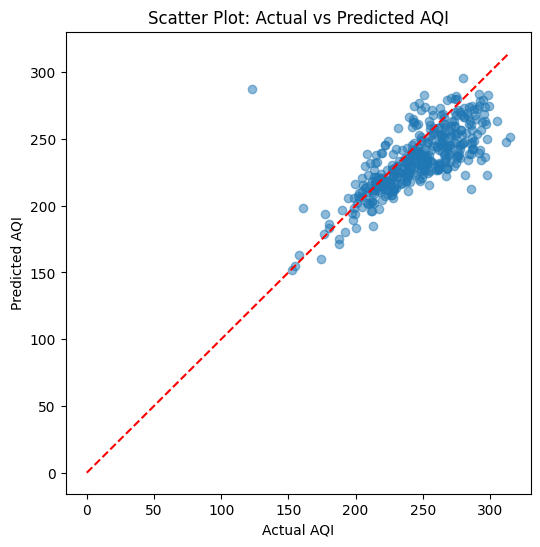

In [41]:
plt.figure(figsize=(6,6))
plt.scatter(true_aqi["AQI"], pred_aqi["AQI"], alpha=0.5)
plt.plot([0, max(true_aqi["AQI"].max(), pred_aqi["AQI"].max())],
         [0, max(true_aqi["AQI"].max(), pred_aqi["AQI"].max())],
         color="red", linestyle="--")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Scatter Plot: Actual vs Predicted AQI")
plt.show()
